In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# !pip install pyLDAvis

In [2]:
review_df = pd.read_csv('./train_food_noun.csv')
review_df.head()

,recipe_id,name,date,review,clean_review,food_noun
0,5315,icy holiday punch,2001-04-24,I brought this to an office holiday party and ...,"['office', 'holiday', 'party']",[]
1,8661,oliveau salad dressing,2001-08-05,Good recipe and easy to make. I found it a li...,"['recipe', 'make', 'bit', 'salad', 'wine', 'di...",[]
2,10859,broccoli cauliflower and rice casserole,2001-08-15,This is a nice casserole. It is very easy to ...,"['casserole', 'put']",[]
3,902,microwaved garlic mushroom rolls,2001-08-16,Very easy to make for a lunch. I served it co...,"['lunch', 'sandwich', 'time', 'cheese', 'chees...","['cheese', 'cheddar']"
4,10722,cherry cream cheese pie,2001-09-04,I like easy and good. I bought the pie shell ...,"['good', 'pie', 'shell', 'whip', 'town', 'guest']",['pie']


# Create Corpus

In [3]:
# change noun review to list
def str_to_list(text):
    text = text[1:len(text)-1]
    text_list = text.split(',')
    text_list = [text.strip()[1:-1] for text in text_list]
    return text_list

In [17]:
# data_lemmatized = review_df['food_noun'].tolist() -> remove & rerun
data_lemmatized = review_df['noun_review'].tolist()
data_lemmatized = [str_to_list(text) for text in data_lemmatized]
data_lemmatized[:10]

[[''],
 [''],
 [''],
 ['cheese', 'cheddar'],
 ['pie'],
 [''],
 [''],
 ['stuff'],
 [''],
 ['stuff']]

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [19]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, ''), (1, 'cheddar'), (2, 'cheese'), (3, 'pie'), (4, 'stuff'), (5, 'desert'), (6, 'corn'), (7, 'rice'), (8, 'side'), (9, 'eater'), (10, 'fish'), (11, 'salmon'), (12, 'onion'), (13, 'notch'), (14, 'banana'), (15, 'pineapple'), (16, 'chocolate'), (17, 'tender'), (18, 'seed'), (19, 'noodle'), (20, 'linguine'), (21, 'vegetable'), (22, 'pasta'), (23, 'tuna'), (24, 'parmesan'), (25, 'salt'), (26, 'bottom'), (27, 'pork'), (28, 'beef'), (29, 'artichoke'), (30, 'bread'), (31, 'cake'), (32, 'proof'), (33, 'brit'), (34, 'chip'), (35, 'butter'), (36, 'water'), (37, 'malt'), (38, 'heat'), (39, 'store'), (40, 'meat'), (41, 'slice'), (42, 'dip'), (43, 'peanut'), (44, 'cut'), (45, 'bar'), (46, 'marzipan'), (47, 'mushroom'), (48, 'stock'), (49, 'liver')]

Total Vocabulary Size: 452


# Building LDA Model

## Hyperparameter Tuning for LDA Model

In [20]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [21]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.36983902768260196
Perplexity Score:  22.08134129845094

topic number:  3
Coherence Score:  0.365860616050822
Perplexity Score:  22.248799089531687

topic number:  4
Coherence Score:  0.35867992647608615
Perplexity Score:  22.79319143115194

topic number:  5
Coherence Score:  0.38953703663033545
Perplexity Score:  22.863135800863787

topic number:  6
Coherence Score:  0.40081627600814035
Perplexity Score:  23.62156856311374

topic number:  7
Coherence Score:  0.3404038817350848
Perplexity Score:  24.407843962418074

topic number:  8
Coherence Score:  0.34158530984029156
Perplexity Score:  25.03497631695328

topic number:  9
Coherence Score:  0.35783473896630114
Perplexity Score:  24.998159183292827

topic number:  10
Coherence Score:  0.37503644221362853
Perplexity Score:  25.51843066504758

topic number:  11
Coherence Score:  0.4218347389882268
Perplexity Score:  26.44407232769198

topic number:  12
Coherence Score:  0.4472881758667005
Perplexity Sc

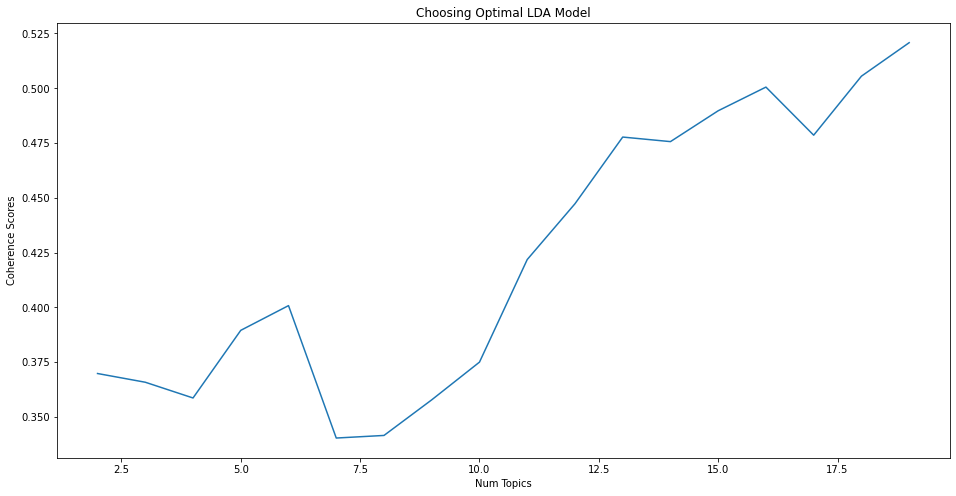

In [22]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

## Final LDA Model

In [23]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=19, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [24]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.376*"onion" + 0.209*"spring" + 0.135*"meat" + 0.124*"top" + 0.038*"stick" '
  '+ 0.037*"leave" + 0.023*"pastry" + 0.017*"caper" + 0.016*"go" + '
  '0.011*"waste"'),
 (1,
  '0.285*"rice" + 0.220*"chocolate" + 0.144*"chip" + 0.100*"cut" + '
  '0.080*"peanut" + 0.059*"cookie" + 0.044*"salmon" + 0.042*"bar" + '
  '0.020*"sprout" + 0.004*"proof"'),
 (2,
  '0.221*"fruit" + 0.171*"sausage" + 0.160*"store" + 0.135*"shrimp" + '
  '0.119*"pineapple" + 0.058*"rib" + 0.057*"smell" + 0.035*"pickle" + '
  '0.018*"dumpling" + 0.016*"drumstick"'),
 (3,
  '0.427*"cake" + 0.398*"mushroom" + 0.081*"list" + 0.032*"leaf" + '
  '0.025*"loin" + 0.010*"fig" + 0.009*"gnocchi" + 0.006*"catch" + '
  '0.005*"liver" + 0.003*"french"'),
 (4,
  '0.303*"pie" + 0.183*"cherry" + 0.121*"paper" + 0.120*"yogurt" + '
  '0.107*"berry" + 0.058*"weather" + 0.042*"leek" + 0.030*"artichoke" + '
  '0.023*"rack" + 0.004*"coal"'),
 (5,
  '0.558*"cheese" + 0.149*"cookie" + 0.077*"cheddar" + 0.064*"dip" + '
  '0.053*"crack

In [25]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [26]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(review_df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])

In [27]:
review_df['Doc'] = doc_num
review_df['Topic'] = topic_num
review_df['Probability'] = prob

In [28]:
df_final = review_df[['recipe_id', 'name', 'date', 'review', 'Doc', 'Topic', 'Probability']]
df_final

,recipe_id,name,date,review,Doc,Topic,Probability
0,5315,icy holiday punch,2001-04-24,I brought this to an office holiday party and ...,0,6,0.526316
1,8661,oliveau salad dressing,2001-08-05,Good recipe and easy to make. I found it a li...,1,6,0.526316
2,10859,broccoli cauliflower and rice casserole,2001-08-15,This is a nice casserole. It is very easy to ...,2,6,0.526316
3,902,microwaved garlic mushroom rolls,2001-08-16,Very easy to make for a lunch. I served it co...,3,5,0.684210
4,10722,cherry cream cheese pie,2001-09-04,I like easy and good. I bought the pie shell ...,4,4,0.526316
...,...,...,...,...,...,...,...
72252,349813,healthier french fries and budget friendly,2010-09-08,This is a really nice basic fries recipe. I li...,72252,12,0.526316
72253,76930,funky chicken with sesame noodles,2010-09-08,Fantastic! My boys devoured it! I used light s...,72253,6,0.526316
72254,214193,no egg tomato soup cake,2010-09-08,"Oh wow, this is a really, really good cake rec...",72254,3,0.350877
72255,177792,chili potato dippers with cheddar jalapeno dip,2010-09-08,"Mmm, yummy!!!! The fries are so spicy and yumm...",72255,5,0.526315


## Model Evaluation

In [29]:
# Compute Perplexity
log_perplexity = lda_model.log_perplexity(corpus)
perplexity = 2**(-log_perplexity)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  50.243767474913625
Coherence Score:  0.5198395077799358


In [30]:
df_final.to_csv("topic_modelling_food_noun.csv", index=False)

# Visualisation

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.067174 -0.032420       1        1  9.717043
1      0.058526  0.315144       2        1  7.899215
0     -0.139540 -0.169195       3        1  7.613791
8     -0.360557  0.038922       4        1  6.675457
5      0.097991  0.283018       5        1  6.518099
17     0.067588 -0.036011       6        1  6.249805
13     0.067340 -0.036215       7        1  5.464271
14    -0.040495 -0.014311       8        1  5.425730
12     0.067110 -0.035980       9        1  5.322508
7      0.066780 -0.035710      10        1  4.922089
15    -0.106407 -0.172603      11        1  4.836203
2      0.066937 -0.036649      12        1  4.695656
3      0.066684 -0.036445      13        1  4.519372
4      0.066304 -0.037149      14        1  3.885840
11     0.066259 -0.036950      15        1  3.838045
9     -0.299724  0.153741      16        1  3.726522
18     0.066506 -0.037028      17        1  3.520191
16     0.064006 -0.037911      18        1  2.906484
10     0.057519 -0.036248      19        1  2.263679, topic_info=         Term          Freq         Total Category  logprob  loglift
0              12700.000000  12700.000000  Default  30.0000  30.0000
2      cheese   4766.000000   4766.000000  Default  29.0000  29.0000
35     butter   4045.000000   4045.000000  Default  28.0000  28.0000
200      game   3123.000000   3123.000000  Default  27.0000  27.0000
25       salt   3452.000000   3452.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
266     diner      0.184082      1.247332  Topic19  -9.6874   1.8748
346  streusel      0.184071      1.247245  Topic19  -9.6874   1.8748
260      pack      0.184073      1.247440  Topic19  -9.6874   1.8747
295      line      0.184054      1.247291  Topic19  -9.6875   1.8747
264     match      0.184054      1.247464  Topic19  -9.6875   1.8745

[746 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.999891           
115       5  0.979296    anchovy
67       10  0.998972      apple
197       7  0.992144    apricot
29       14  0.992530  artichoke
...     ...       ...        ...
130       3  0.991731      waste
36        6  0.999589      water
144      14  0.995512    weather
101       9  0.999286      wheat
165      14  0.998548     yogurt

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 1, 9, 6, 18, 14, 15, 13, 8, 16, 3, 4, 5, 12, 10, 19, 17, 11])

## Word Count of Topic Keywords

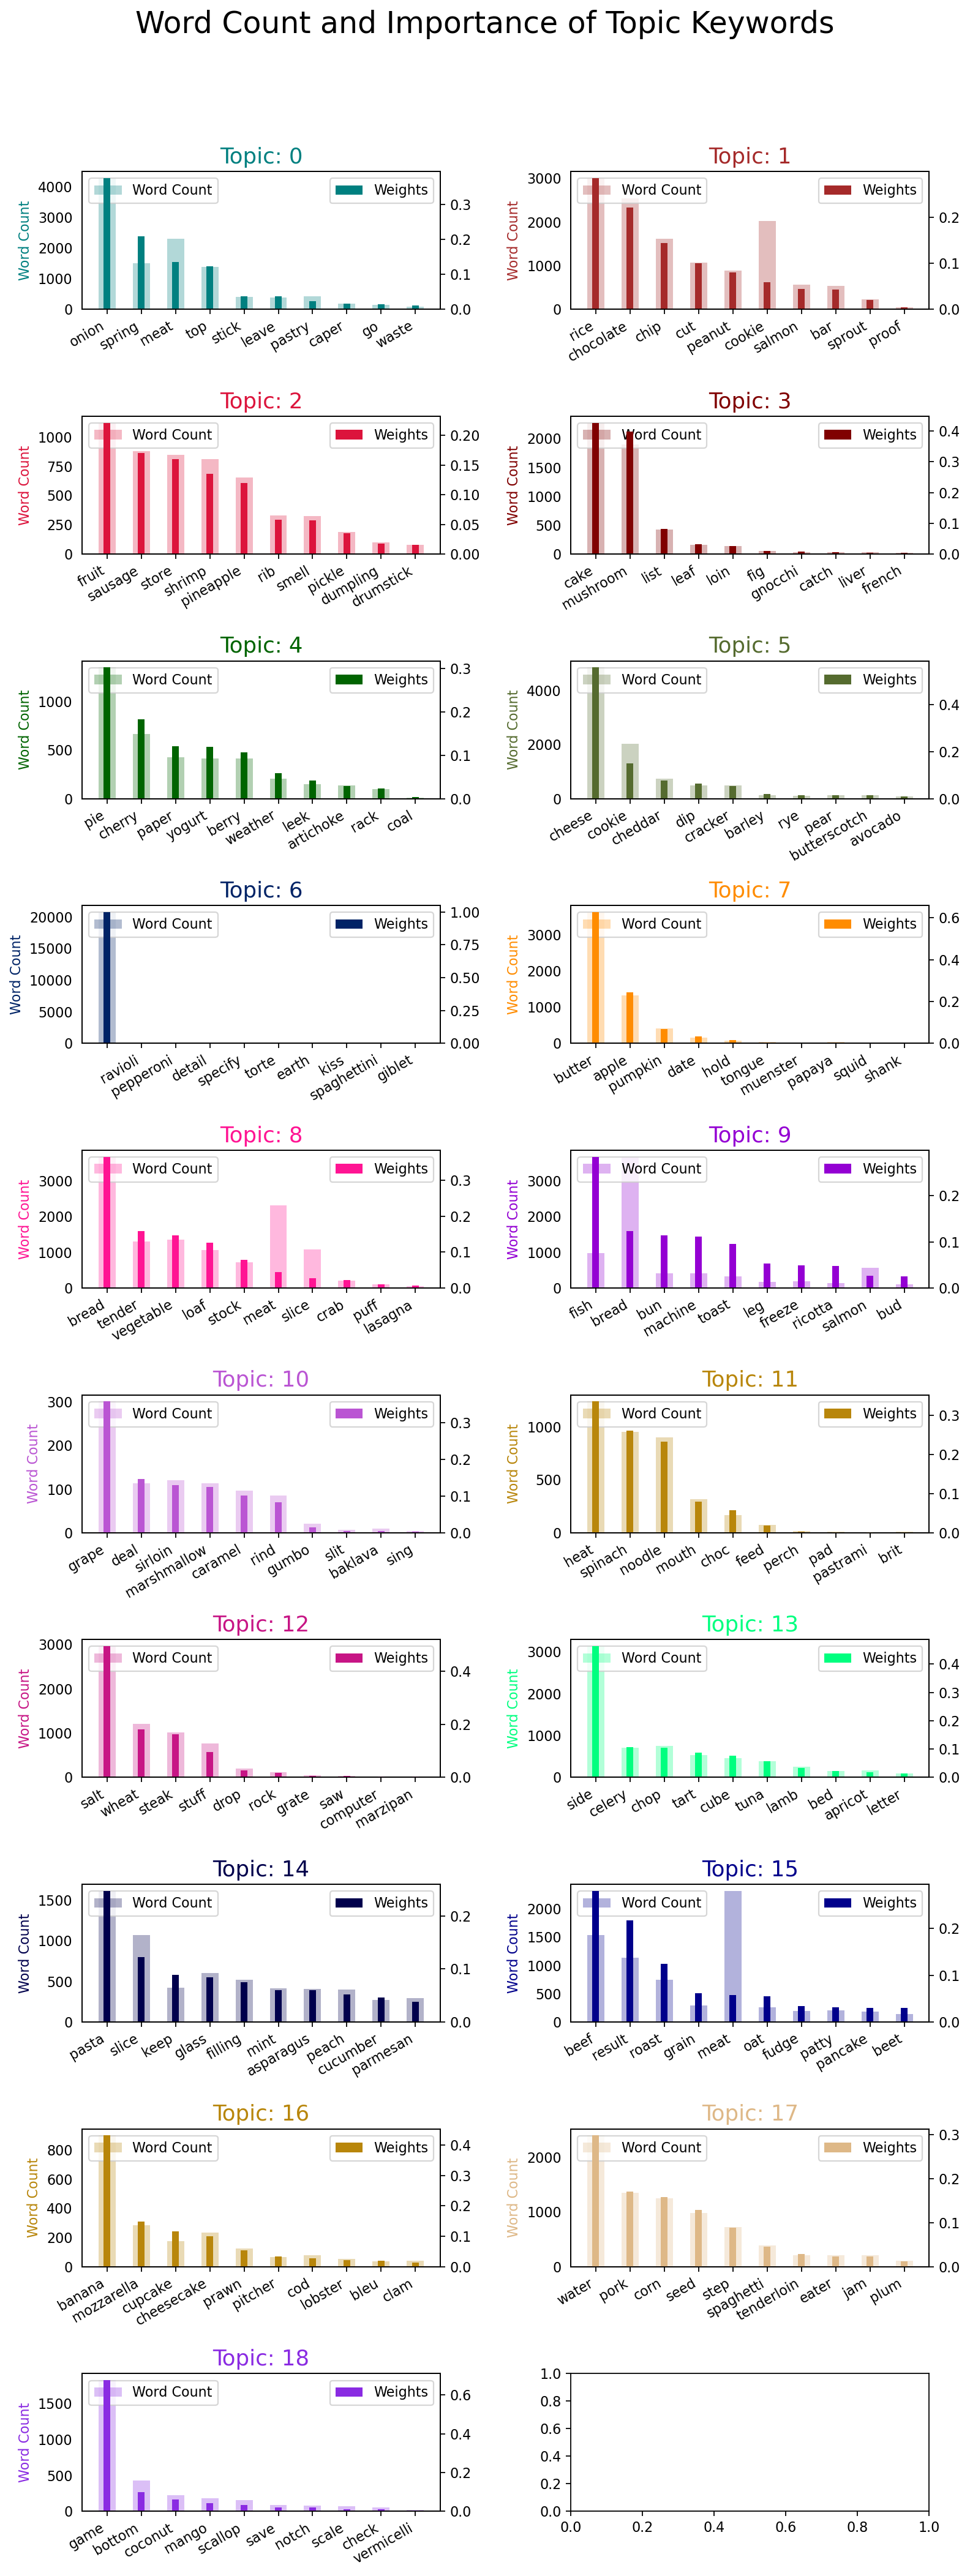

In [39]:
from collections import Counter

num_topics = 19

topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(10, 2, figsize=(10,25), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2']

for i, ax in enumerate(axes.flatten()):
    if i > num_topics - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()